# Exploratory Data Analysis (EDA)
## nPulse Sensor Data Analysis

In [31]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading

In [82]:
data_path = Path('../data/badr-data/raw')
csv_files = list(data_path.glob('*.csv'))

# Load first file as sample
df = pd.read_csv(csv_files[0])
print(f"Shape: {df.shape}")
df.head()

Shape: (15513, 6)


,Timestamp,Channel1,Channel2,Channel3,Action1,Action2
0,0.000,677.859866,1164.716559,717.733847,Rest,NaN
1,0.282,668.390195,1165.841803,695.476999,Rest,NaN
2,0.285,669.773064,1165.709453,693.656169,Rest,NaN
3,0.288,670.606267,1165.900061,670.324506,Rest,NaN
4,0.291,672.538846,1166.019899,672.959012,Rest,NaN


In [54]:
# Number of rows where both Action1 and Action2 are not NaN
num_valid_rows = df[df['Action2'].notna()].shape[0]
num_valid_rows

2776

In [47]:
# Load sample cleaned data
data_path_ws = Path('../data/data_rpi/cleaned')
csv_files_ws = list(data_path_ws.glob('*.csv'))

# Load first file as sample
df_ws = pd.read_csv(csv_files_ws[0])
print(f"Shape: {df_ws.shape}")
df_ws.head()

Shape: (15902, 5)


,Timestamp,Channel1,Channel2,Channel3,Gesture
0,0.279,3.946817,0.194623,681.394175,0
1,0.282,5.675466,0.245992,686.785627,0
2,0.285,6.554836,0.420930,703.497450,0
3,0.288,5.612703,0.182997,698.442861,0
4,0.291,2.819258,0.234051,689.405650,0


In [41]:
df[df['Action1'] == 'Rest']

,Timestamp,Channel1,Channel2,Channel3,Action1,Action2


## 2. Data Overview

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15513 entries, 0 to 15512
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  15513 non-null  float64
 1   Channel1   15513 non-null  float64
 2   Channel2   15513 non-null  float64
 3   Channel3   15513 non-null  float64
 4   Action1    15513 non-null  object 
 5   Action2    2776 non-null   object 
dtypes: float64(4), object(2)
memory usage: 727.3+ KB


In [51]:
df.describe()

,Timestamp,Channel1,Channel2,Channel3
count,15513.000000,15513.000000,15513.000000,15513.000000
mean,23.725251,672.786992,1164.492045,686.230166
std,13.530123,31.469485,0.644470,12.626719
min,0.000000,152.416469,1155.966634,620.765859
25%,12.013000,663.503795,1164.066257,677.303260
50%,23.730000,671.063192,1164.199573,686.178432
75%,35.449000,679.008707,1164.887997,695.091922
max,47.040000,1268.757280,1171.574285,794.410361


In [79]:
# Check for missing values and unique gestures
print("Missing Values:")
print(df.isnull().sum())
print(f"\nUnique Gestures: {df['Action1'].unique()}")
print(f"Gesture Distribution:\n{df['Action1'].value_counts()}")

Missing Values:
Timestamp        0
Channel1         0
Channel2         0
Channel3         0
Action1          0
Action2      12737
dtype: int64

Unique Gestures: ['Rest' 'WristExt' 'WristFlexion' 'WristRotIn' 'WristRotExt' 'Fist' 'Palm']
Gesture Distribution:
Action1
Rest            8371
Fist            1270
WristFlexion    1219
Palm            1208
WristRotIn      1175
WristExt        1159
WristRotExt     1111
Name: count, dtype: int64


## 3. Visualization

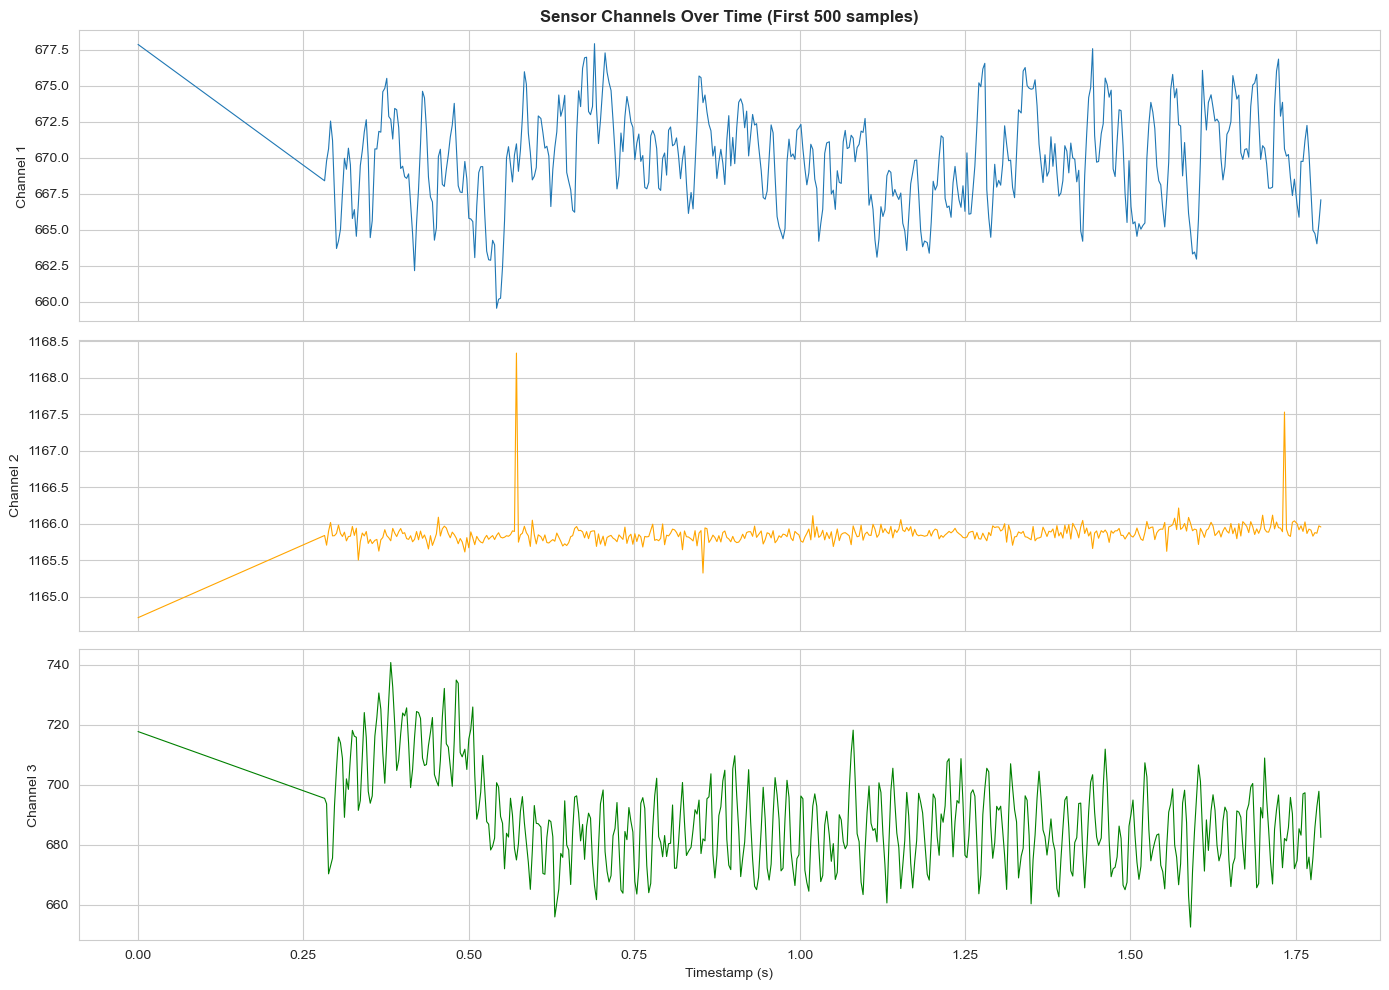

In [81]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
sample_data = df.head(500)  # Plot first 500 samples for clarity

axes[0].plot(sample_data['Timestamp'], sample_data['Channel1'], linewidth=0.8)
axes[0].set_ylabel('Channel 1', fontsize=10)
axes[0].set_title('Sensor Channels Over Time (First 500 samples)', fontsize=12, fontweight='bold')

axes[1].plot(sample_data['Timestamp'], sample_data['Channel2'], linewidth=0.8, color='orange')
axes[1].set_ylabel('Channel 2', fontsize=10)

axes[2].plot(sample_data['Timestamp'], sample_data['Channel3'], linewidth=0.8, color='green')
axes[2].set_ylabel('Channel 3', fontsize=10)
axes[2].set_xlabel('Timestamp (s)', fontsize=10)

plt.tight_layout()
plt.show()

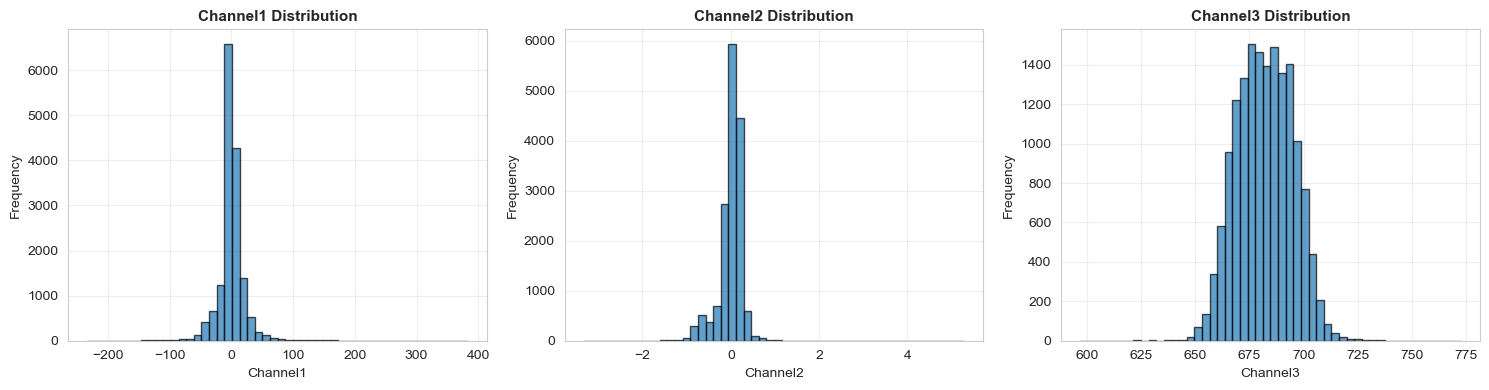

In [6]:
# Distribution of sensor channels
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, channel in enumerate(['Channel1', 'Channel2', 'Channel3']):
    axes[idx].hist(df[channel], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(channel, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'{channel} Distribution', fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

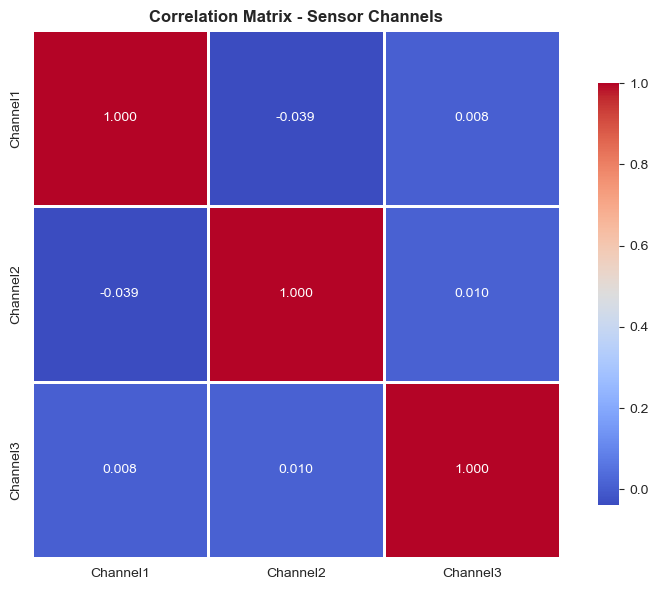


Correlation Matrix:
          Channel1  Channel2  Channel3
Channel1  1.000000 -0.039463  0.008355
Channel2 -0.039463  1.000000  0.010480
Channel3  0.008355  0.010480  1.000000


In [7]:
# Get the order and duration of gestures
# Assumes 'Gesture' and 'Timestamp' columns exist and are sorted by time

gesture_changes = df['Gesture'].ne(df['Gesture'].shift()).cumsum()
gesture_groups = df.groupby(gesture_changes)

order_and_duration = []
for _, group in gesture_groups:
    gesture = group['Gesture'].iloc[0]
    start_time = group['Timestamp'].iloc[0]
    end_time = group['Timestamp'].iloc[-1]
    duration = end_time - start_time
    order_and_duration.append({'Gesture': gesture, 'Start': start_time, 'End': end_time, 'Duration': duration})

order_and_duration_df = pd.DataFrame(order_and_duration)
order_and_duration_df[['Gesture', 'Duration']]# Correlation heatmap
correlation_matrix = df[['Channel1', 'Channel2', 'Channel3']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Sensor Channels', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(correlation_matrix)

In [84]:
# Get the order and duration of gestures
gesture_changes = df['Action1'].ne(df['Action1'].shift()).cumsum()
gesture_groups = df.groupby(gesture_changes)

order_and_duration = []
for _, group in gesture_groups:
    gesture = group['Action1'].iloc[0]
    start_time = group['Timestamp'].iloc[0]
    end_time = group['Timestamp'].iloc[-1]
    duration = end_time - start_time
    order_and_duration.append({'Gesture': gesture, 'Start': start_time, 'End': end_time, 'Duration': duration})

order_and_duration_df = pd.DataFrame(order_and_duration)
order_and_duration_df#[['Gesture', 'Duration']]

,Gesture,Start,End,Duration
0,Rest,0.000,3.475,3.475
1,WristExt,3.481,6.980,3.499
2,Rest,6.985,10.707,3.722
3,WristFlexion,10.713,14.396,3.683
4,Rest,14.402,18.238,3.836
5,WristRotIn,18.243,21.787,3.544
6,Rest,21.793,25.604,3.811
7,WristRotExt,25.610,28.963,3.353
8,Rest,28.968,32.891,3.923
9,Fist,32.897,36.730,3.833


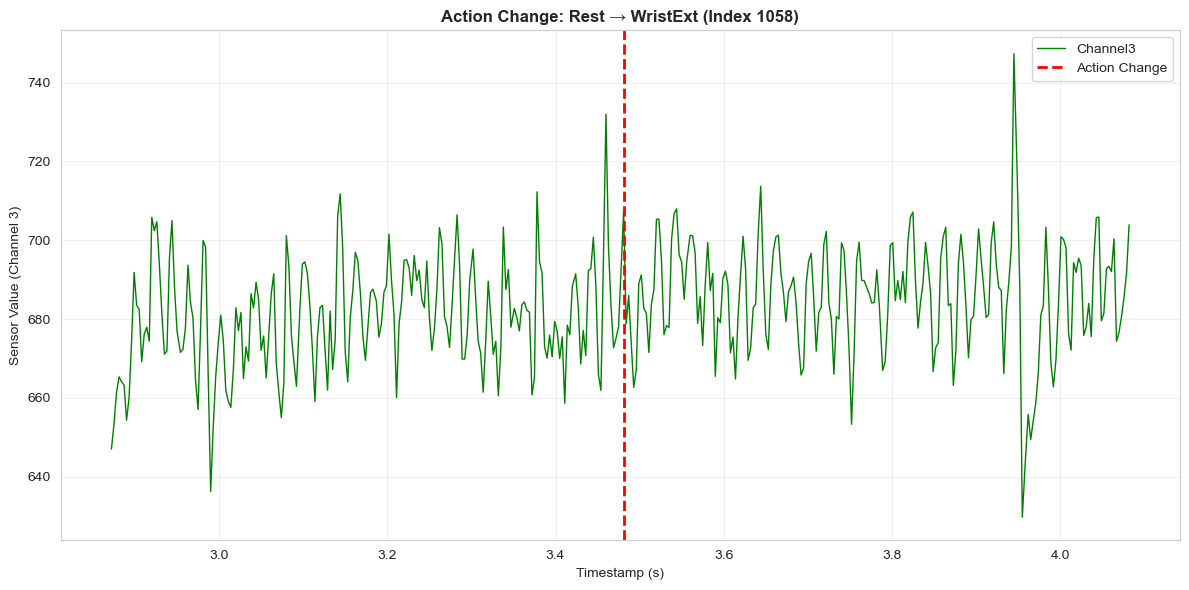

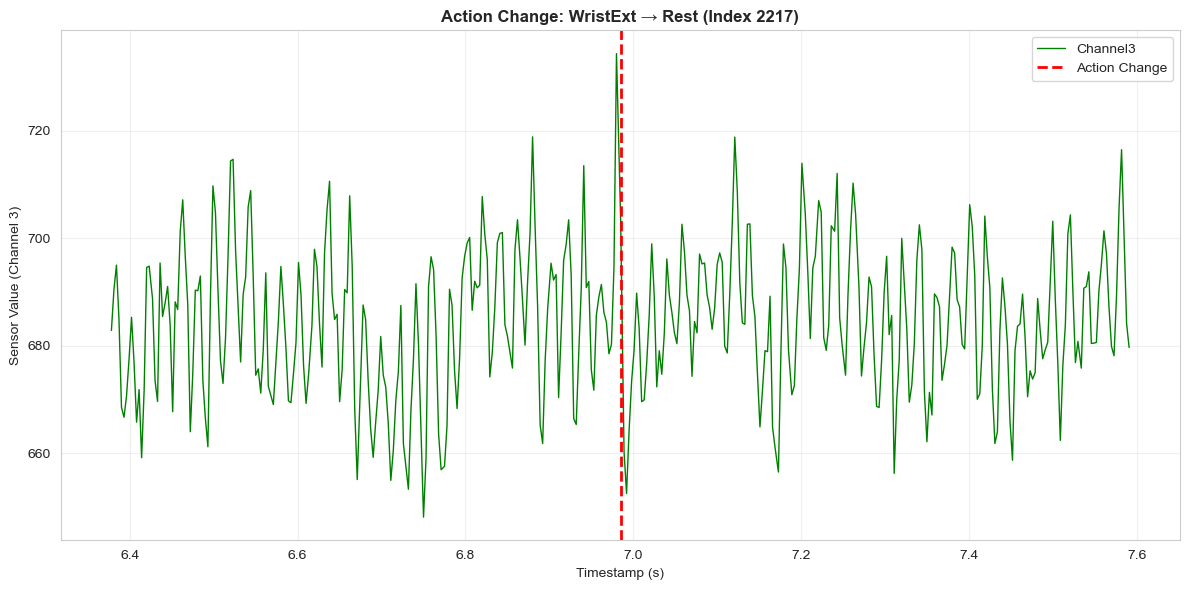

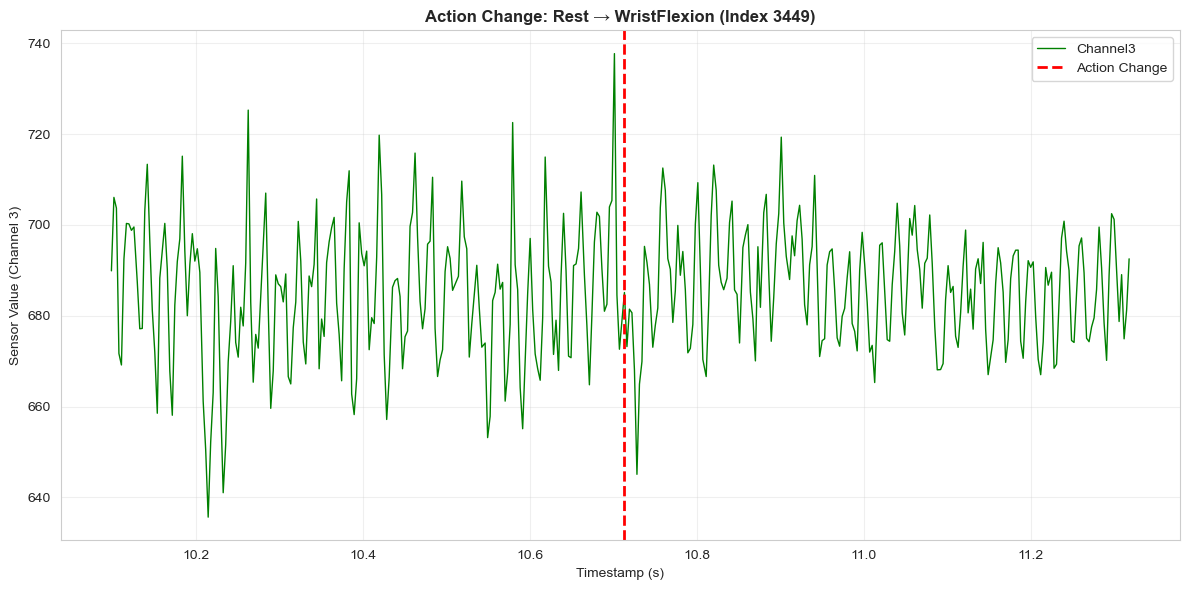

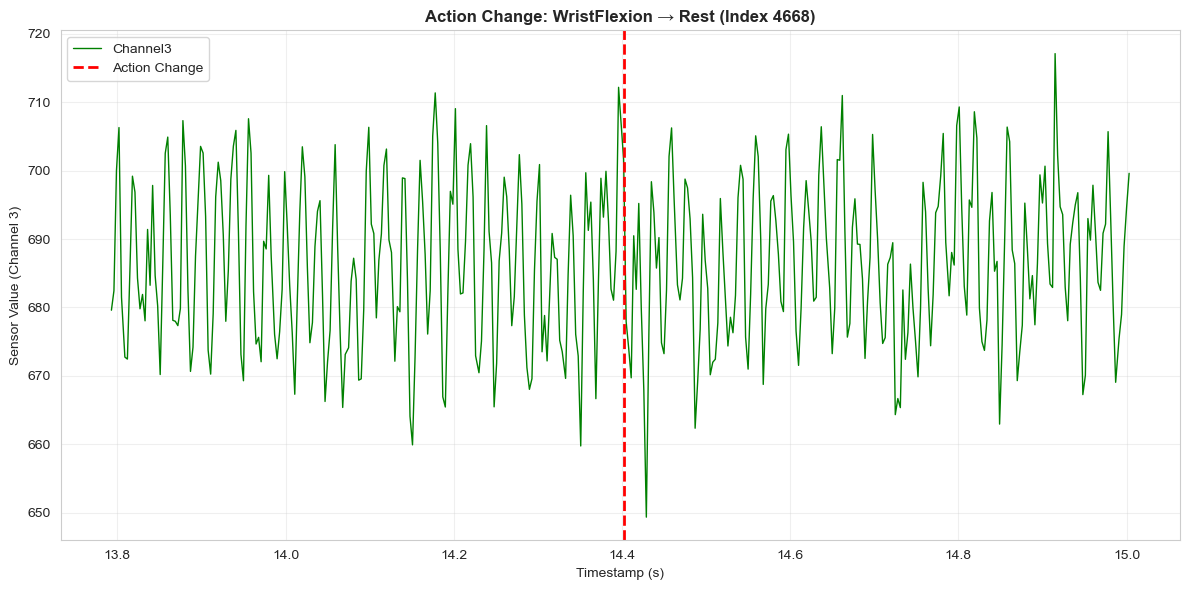

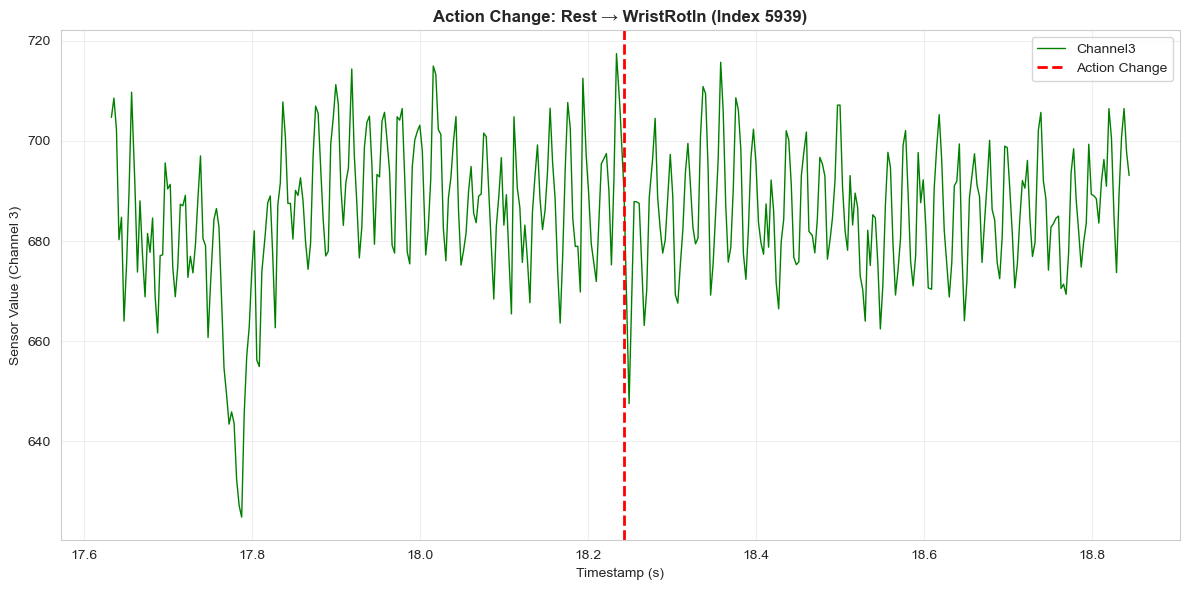

In [86]:
# Plot sensor channels around action changes
import matplotlib.pyplot as plt

# Find indices where Action1 changes (skip the first row if it's the start)
change_indices = df[df['Action1'].ne(df['Action1'].shift())].index[1:]

# Define window size (number of samples before and after change)
window = 200

# Plot for each change (limit to first 5 for brevity)
for i, idx in enumerate(change_indices[:5]):
    start_idx = max(0, idx - window)
    end_idx = min(len(df) - 1, idx + window)
    
    subset = df.iloc[start_idx:end_idx]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(subset['Timestamp'], subset['Channel3'], label='Channel3', linewidth=1, color='green')
    
    # Mark the change point
    change_time = df.loc[idx, 'Timestamp']
    ax.axvline(x=change_time, color='red', linestyle='--', linewidth=2, label='Action Change')
    
    # Get action before and after
    prev_action = df.loc[idx-1, 'Action1'] if idx > 0 else 'Start'
    current_action = df.loc[idx, 'Action1']
    
    ax.set_title(f'Action Change: {prev_action} → {current_action} (Index {idx})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Timestamp (s)', fontsize=10)
    ax.set_ylabel('Sensor Value (Channel 3)', fontsize=10)
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4. Multi-file Analysis

In [8]:
# Load and analyze all cleaned files
all_data = []
for file in csv_files:
    if file.stat().st_size > 0:  # Skip empty files
        temp_df = pd.read_csv(file)
        temp_df['file'] = file.name
        all_data.append(temp_df)

# Combine all data
df_all = pd.concat(all_data, ignore_index=True)
print(f"Total combined shape: {df_all.shape}")
print(f"\nGesture distribution across all files:")
print(df_all['Gesture'].value_counts())
print(f"\nFiles processed: {len(all_data)}")

Total combined shape: (110278, 6)

Gesture distribution across all files:
Gesture
0     58486
6      9043
10     8714
9      8637
5      8621
14     8424
13     8353
Name: count, dtype: int64

Files processed: 7


In [25]:
df_all[df_all['Gesture'] == ]

,Timestamp,Channel1,Channel2,Channel3,Gesture,file
8257,25.274,11.108097,0.130020,699.772516,10,WS_R_ch3_seq4_250523180349_cleaned.csv
8258,25.277,9.530342,0.100874,672.854522,10,WS_R_ch3_seq4_250523180349_cleaned.csv
8259,25.280,12.064251,0.081490,659.806946,10,WS_R_ch3_seq4_250523180349_cleaned.csv
8260,25.283,11.171439,0.148780,660.107617,10,WS_R_ch3_seq4_250523180349_cleaned.csv
8261,25.286,12.035562,0.710903,677.937776,10,WS_R_ch3_seq4_250523180349_cleaned.csv
...,...,...,...,...,...,...
104040,28.321,-12.321219,-0.405354,685.051644,10,WS_R_ch3_seq4_250523180502_cleaned.csv
104041,28.324,-8.778728,-0.330602,680.249236,10,WS_R_ch3_seq4_250523180502_cleaned.csv
104042,28.327,-5.820414,-0.219083,684.627824,10,WS_R_ch3_seq4_250523180502_cleaned.csv
104043,28.330,-6.865245,-0.387989,684.188300,10,WS_R_ch3_seq4_250523180502_cleaned.csv


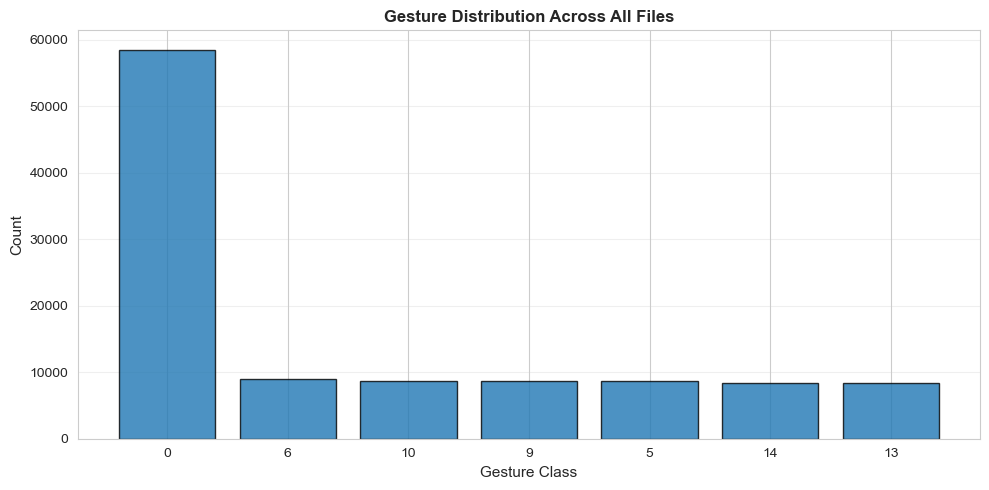

In [9]:
# Gesture distribution visualization
plt.figure(figsize=(10, 5))
gesture_counts = df_all['Gesture'].value_counts()
plt.bar(gesture_counts.index.astype(str), gesture_counts.values, edgecolor='black', alpha=0.8)
plt.xlabel('Gesture Class', fontsize=11)
plt.ylabel('Count', fontsize=11)
plt.title('Gesture Distribution Across All Files', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Key Findings

**Data Structure:**
- 3 sensor channels (Channel1, Channel2, Channel3)
- Timestamp column for temporal analysis
- Gesture labels for classification
- Multiple CSV files representing different recording sessions

**Observations:**
- Data appears to be from capacitive/proximity sensors
- Channel3 shows significantly larger magnitude values
- Temporal patterns visible in time-series data
- Multiple gesture classes present in the dataset